In [4]:
import json
import nxviz as nv
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches
import string

/usr/local/lib/python3.12/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [5]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

In [6]:
def dictdiv(num, denom):
  o = {}
  for i in num:
    o[i] = num[i] / denom[i]

In [7]:
file = open("Data/final_demand_gtap.json", "r")
final_demand_gtap = file.read()
final_demand_gtap = json.loads(final_demand_gtap)

In [8]:
consumption_concentration_gtap = pd.read_csv('First_review_data/S7.csv',header=None)

In [9]:
consumption_concentration_gtap.columns = list(final_demand_gtap.keys())

In [10]:
consumption_concentration_gtap = consumption_concentration_gtap.astype(float)

In [11]:
countries = [
          'USA', "GBR","FRA", "DEU", # top 4 Net exporters
          "BGD", "IDN", "IND", "CHN", # top 4 net importers
          ]

In [12]:
production_concentration_gtap = pd.DataFrame()
for country in countries:
  shp = pd.read_csv('First_review_data/S5/'+str(country)+'.csv',index_col=0)
  production_concentration_gtap[country] = shp.sum(axis=1)

In [13]:
production_concentration_gtap = production_concentration_gtap.astype(float)

In [14]:
cut = 5 # percentile for clipping color scale

diff = np.zeros((consumption_concentration_gtap.shape[0], len(countries)))
for i, c in enumerate(countries):
      diff[:, i] = consumption_concentration_gtap[c] - production_concentration_gtap[c]
cutpt = max(abs(np.percentile(list(diff),cut)), abs(np.percentile(list(diff),100-cut)))

In [15]:
df_shp_gtap = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')
robinson = ccrs.Robinson().proj4_init
df_shp_gtap = df_shp_gtap.to_crs(robinson)

In [16]:
layout = {}
for i, c in enumerate(df_shp_gtap.ADM0_A3):
  p = df_shp_gtap.centroid[i]
  layout[c] = [p.x, p.y]

In [17]:
# population
file = open("First_review_data/Total_pop_gtap.json", "r")
population_gtap = file.read()
population_gtap = json.loads(population_gtap)

In [18]:
con_mort_tol_gtap = pd.read_csv('First_review_data/S3.csv',index_col=0)
# Row sum: total deaths happen in that country
con_total_gtap = dict(con_mort_tol_gtap.sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_gtap = dict(con_mort_tol_gtap.sum(axis=0))

In [19]:
Gtap_regions = {'PRI':['PRI'],
               'XCB':['AIA','ATG','ABW','BHS','BRB','VGB','CYM','CUB','DMA','GRD','HTI','MSR','KNA','LCA','VCT','TCA','VIR'],
               'XCF':['CAF','TCD','COG','GNQ','GAB','STP'],
               'XEC':['BDI','COM','DJI','ERI','SYC','SOM','SDN'], # gtap ONLY contains Sudan, without South Sudan
               'XER':['AND','BIH','GIB','GGY','VAT','IMN','JEY','MKD','MCO','MNE','SMR','SRB'],
               'XNA':['BMU','GRL','SPM'],
               'XNF':['DZA','LBY','SAH'], # 'SAH' is changed from 'ESH': Western Sahara
               'XOC':['ASM','COK','FJI','PYF','GUM','KIR','MHL','FSM','NRU','NCL','NIU','MNP','PLW','PNG','PCN','WSM','SLB',
                      'TON','TUV','VUT','WLF'], #'TKL' Tokelau is removed since it's counted as New Zealand
               'XSE':['MMR','TLS'],
               'XSM':['FLK','GUY','SUR'],
               'XWF':['CPV','GMB','GNB','LBR','MLI','MRT','NER','SHN','SLE'],
               'XAC':['AGO','COD'],
               'XEA':['PRK','MAC'],
               'XSA':['AFG','BTN','MDV'],
               'XSC':['LSO','SWZ'],
               'XSU':['TKM','UZB'],
               'XWS':['IRQ','LBN','PSX','YEM','SYR'],
               'XEF':['ISL','LIE'],
               'XCA':['BLZ'],
               'XEE':['MDA']}
                #XTW # the rest of the world

In [20]:
# convert csv to dict
nested_dict = {
    col: con_mort_tol_gtap[col].to_dict()
    for col in con_mort_tol_gtap.columns
}

In [21]:
_# Calculate death exports.
# TODO: I'm not sure whether this is the correct way to do this calculation # Yes
# TODO: A lot of countries in africa are missing! # Done
df_shp_gtap["death_exports"] = np.nan
df_shp_gtap["death_exports_raw"] = np.nan # without clipping
df_shp_gtap["death_exports_tol"] = np.nan

df_shp_gtap.ADM0_A3

for i, s in enumerate(nested_dict):
  if s != 'XTW': # get rid of the rest of the world in the plot
    totalexp = 0
    for d in nested_dict[s]: # include the rest of the world in calculation
        exp = nested_dict[s][d]  # Number of deaths caused by country s and occurring in country d (export of death of country s)
        inp = nested_dict[d][s]  # Number of deaths occurring in country s and caused by country d (import death of country s)
        netexp = exp - inp
        totalexp += netexp
    if s[0] == 'X':
        for member_country in Gtap_regions[s]: # Assign the value of the aggregated region to its member countires
            ii = df_shp_gtap.index[df_shp_gtap.ADM0_A3 == member_country][0]
            df_shp_gtap.death_exports_tol[ii] = totalexp
            df_shp_gtap.death_exports_raw[ii] = totalexp / population_gtap[s] * 1e6
            df_shp_gtap.death_exports[ii] = max(min(totalexp / population_gtap[s] * 1e6, 600), -500) # Exported deaths per million people, clipped at 500

    else:
        ii = df_shp_gtap.index[df_shp_gtap.ADM0_A3 == s][0]
        df_shp_gtap.death_exports_tol[ii] = totalexp
        df_shp_gtap.death_exports_raw[ii] = totalexp / population_gtap[s] * 1e6
        df_shp_gtap.death_exports[ii] = max(min(totalexp / population_gtap[s] * 1e6, 600), -500)  # Exported deaths per million people, clipped at 500


/tmp/ipython-input-1694370928.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_shp_gtap.death_exports_tol[ii] = totalexp
/tmp/ipython-input-1694370928.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [22]:
x_max = df_shp_gtap.death_exports_tol.max()
x_min = df_shp_gtap.death_exports_tol.min()

In [23]:
import networkx as nx
G = nx.DiGraph()

for c in population_gtap:
  if c[0] != 'X':
    G.add_nodes_from([(c, {"pop": population_gtap[c],"continent":df_shp_gtap[df_shp_gtap['ADM0_A3']==c].CONTINENT.values[0]})])
  elif c[0] == 'X' and c != 'XTW':
    G.add_nodes_from([(c, {"pop": population_gtap[c],"continent":df_shp_gtap[df_shp_gtap['ADM0_A3']==Gtap_regions[c][0]].CONTINENT.values[0]})])
  else:
    G.add_nodes_from([(c, {"pop": population_gtap[c],"continent":'Rest of the world'})])


for s in population_gtap:
  for d in population_gtap:
    exp = con_mort_tol_gtap[s][d]
    imp = con_mort_tol_gtap[d][s]
    if exp > imp:
      G.add_edges_from([(s, d, {
          "con_exp_deaths": exp-imp,
          # "width": (((exp-imp) - x_min) / (x_max - x_min)) * 10
          })])

In [24]:
G_df = pd.DataFrame(G.edges.data())
G_df.columns = ['From','To','Values']
G_df['Values'] = [a['con_exp_deaths'] for a in G_df['Values']]

In [25]:
G_df.sort_values(by=['Values'], ascending=False,inplace=True)

In [26]:
unique_countries = set(G_df['To'].unique()).union(set(G_df['From'].unique()))

In [27]:
net_import_ratio = {}
net_export_ratio = {}
for i in unique_countries:
  From = len(G_df[G_df['From'] == i])
  To = len(G_df[G_df['To'] == i])
  all_relationship = From + To
  net_import_ratio[i] = To/all_relationship
  net_export_ratio[i] = From/all_relationship

In [28]:
sorted(net_import_ratio.items(), key=lambda x:x[1],reverse=True)[:8]

[('XSC', 1.0),
 ('CHN', 0.9785714285714285),
 ('XEA', 0.9785714285714285),
 ('XSA', 0.9428571428571428),
 ('NPL', 0.9357142857142857),
 ('BGD', 0.9357142857142857),
 ('KHM', 0.9357142857142857),
 ('XSE', 0.9285714285714286)]

In [29]:
sorted(net_export_ratio.items(), key=lambda x:x[1],reverse=True)[:10]

[('XNA', 1.0),
 ('XTW', 1.0),
 ('XEF', 1.0),
 ('XOC', 0.9785714285714285),
 ('NOR', 0.9714285714285714),
 ('XSM', 0.9571428571428572),
 ('IRL', 0.95),
 ('PRI', 0.9428571428571428),
 ('LUX', 0.9428571428571428),
 ('XCA', 0.9428571428571428)]

In [30]:
G_df.to_csv("First_review_data/S9.csv")

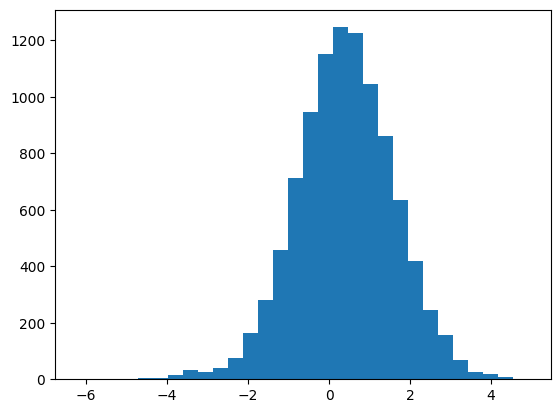

In [31]:
con_exp_deaths = np.zeros(len(G.edges))
ced = nx.get_edge_attributes(G, "con_exp_deaths")
for i, e in enumerate(G.edges):
  con_exp_deaths[i] = ced[e]
plt.hist(np.log10(con_exp_deaths), bins=30);

In [32]:
cut = np.percentile(con_exp_deaths, 99.6)
cut

np.float64(3572.8962360006612)

In [33]:
H = G.copy()
for i, e in enumerate(list(H.edges)):
  if con_exp_deaths[i] < cut: H.remove_edge(e[0], e[1])

for i, n in enumerate(list(H.nodes)):
  if H.degree[n] < 1: H.remove_node(n)

In [34]:
H.number_of_edges()

40

In [35]:
mapping = {}
for i in H.nodes:
  if i[0] != 'X':
    name = df_shp_gtap[df_shp_gtap['ADM0_A3']==i].ADMIN.values[0]
    if name == 'United States of America': name = 'United States'
    mapping[i] = name
  else:
    mapping['XEA'] = 'Rest of East Asia'
H = nx.relabel_nodes(H, mapping)

In [36]:
# store the top flow in order to create chord diagram
chord_plot_df = pd.DataFrame(H.edges.data())
chord_plot_df.columns = ['From','To','Values']
chord_plot_df['Values'] = [a['con_exp_deaths'] for a in chord_plot_df['Values']]
chord_plot_df.to_csv("First_review_data/chord_plot_gtap.csv")

In [37]:
# Prune network
for i, e in enumerate(list(G.edges)):
  if con_exp_deaths[i] < cut: G.remove_edge(e[0], e[1])
  elif (e[0][0] == "X") | (e[1][0] == "X"):  G.remove_edge(e[0], e[1])
for i, n in enumerate(list(G.nodes)):
  if G.degree[n] < 1: G.remove_node(n)

In [38]:
edgevals = np.array([ced[e] for e in G.edges])

In [39]:
edge_dict = {}
for i, e in enumerate(G.edges):
  edge_dict[e] = ced[e]

In [40]:
filtered_df = df_shp_gtap[['ADM0_A3', 'death_exports_raw', 'death_exports_tol','geometry']].dropna(subset=['death_exports_tol'])

In [41]:
filtered_df.to_csv("First_review_data/Figure1_data.csv")

In [42]:
wholeworld = gpd.read_file('Data/output_wholeworld/wholeworld_bio.shp')
wholeworld = gpd.GeoDataFrame(wholeworld)
robinson = ccrs.Robinson().proj4_init
wholeworld = wholeworld.to_crs(robinson)

0


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


1
2
3
4
5
6
7


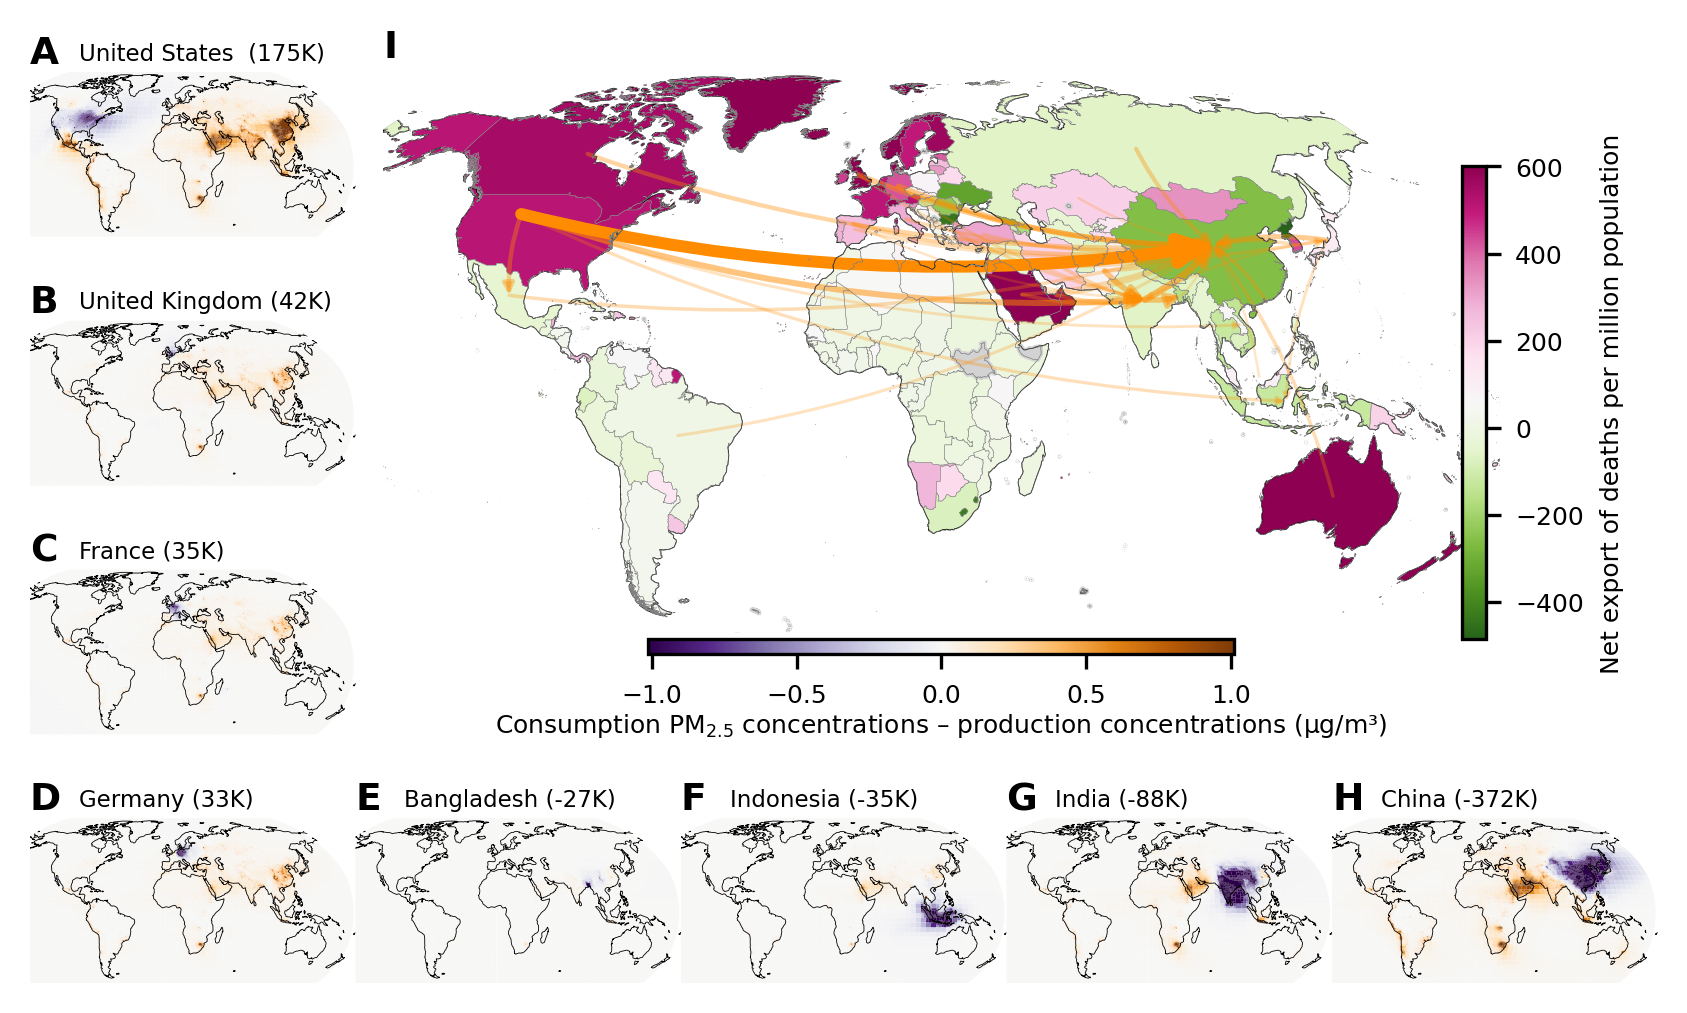

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import string
import matplotlib as mpl
import cartopy.crs as ccrs

# Assuming you have defined G, df_shp_gtap, wholeworld, layout, cutpt, diff, countries, edgevals elsewhere

plt.rcParams.update({'font.size': 6})
fig = plt.figure(figsize=(7, 4), dpi=300)
gs = fig.add_gridspec(4, 5)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

ax = fig.add_subplot(gs[0:3, 1:5], projection=ccrs.Robinson())

df_shp_gtap.plot(linewidths=1, ax=ax, column="death_exports", cmap="PiYG_r", missing_kwds={
    "color": "lightgrey",
    "edgecolor": "lightgrey",
    "hatch": "/ / / /",
    "label": "Missing values",
}, legend_kwds={'fmt': "{:.2f}"})

df_shp_gtap.boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')

ax.coastlines(linewidths=0.2)
ax.axis('off')
ax.set_title(f'I', loc='left', pad=0, fontsize=9, fontweight='bold')
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

mn = df_shp_gtap.death_exports.min()
mx = df_shp_gtap.death_exports.max()
norm = mpl.colors.Normalize(vmin=mn, vmax=mx)
n_cmap = mpl.cm.ScalarMappable(norm=norm, cmap="PiYG_r")
n_cmap.set_array([])
fig.colorbar(n_cmap, ax=ax, orientation='vertical', aspect=20, shrink=0.7,
             pad=-0.05,
             label="Net export of deaths per million population")

norm = mpl.colors.Normalize(vmin=-cutpt, vmax=cutpt)
n_cmap = mpl.cm.ScalarMappable(norm=norm, cmap="PuOr_r")
n_cmap.set_array([])
cb = fig.colorbar(n_cmap, ax=ax, orientation='horizontal', aspect=40, shrink=0.5,
                  pad=0.01)
cb.set_label(r"Consumption PM$_{2.5}$ concentrations – production concentrations (μg/m³)",
              labelpad=1)

linevals = edgevals**0.5 / 100

edges = nx.draw_networkx_edges(G, layout, node_size=0, connectionstyle='arc3, rad = 0.1',
                               arrowsize=list(linevals * 5),
                               width=linevals,
                               edge_color='darkorange',
                               ax=ax)

for i in range(G.number_of_edges()):
    edges[i].set_alpha(linevals[i]/linevals.max())

locs = [[0, 0], [1, 0], [2, 0], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4]]
for i, loc in enumerate(locs):
    print(i)
    ax = fig.add_subplot(gs[loc[0], loc[1]], projection=ccrs.Robinson())
    wholeworld.plot(linewidths=0, column=diff[:, i], ax=ax, vmin=-cutpt, vmax=cutpt, cmap="PuOr_r", legend=False)
    # wholeworld.boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
    ax.coastlines(linewidths=0.2)
    ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=1.5, fontsize=9, fontweight='bold')
    ax.text(0.15, 1.07, f"{df_shp_gtap[df_shp_gtap['ADM0_A3']==countries[i]].NAME.values[0][:14]} ({str(int(df_shp_gtap[df_shp_gtap['ADM0_A3']==countries[i]].death_exports_tol.values[0]/1000))+'K'})",
            fontsize=5.5, transform=ax.transAxes)
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    ax.axis('off')

fig.subplots_adjust(wspace=-0.0, hspace=0.4)

# Save the figure as a PDF with 300 dpi
# plt.savefig('First_review_plot/Fig1_GTAP.pdf', dpi=300)
plt.savefig('First_review_plot/Fig1_GTAP.jpg', dpi=300)